In [1]:
import numpy as np, os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings(action='ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

print(tf.__version__)
print(keras.__version__)

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

2.5.0
2.5.0


# 필요한 데이터 로드, split

In [2]:
import random    
seed_num = 42
random.seed(seed_num)
path = '/project/LSH/'
X = np.load(path + 'x_(7727,10,4068).npy')
y = np.load(path + 'y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[idx[:i],:,:], y[idx[:i]]
X_test, y_test = X[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4068), (6182,), (1545, 10, 4068), (1545,))

In [3]:
#FI에 Type 붙여서 새로 저장 - 다시 실행할 필요 X
# fi = pd.read_csv(path + 'df_all_best.csv').sort_values('diff', ascending=False)
# merge_data = pd.read_csv('/project/guri/data/merge_data.csv')[['ITEM','Type']]
# merge_data = merge_data.drop_duplicates().rename(columns = {'ITEM':'feature'})
# fi_type = pd.merge(fi, merge_data, how='left', on='feature')
# fi_type.to_csv('./data/df_all_best_type.csv', index=False)

In [4]:
fi = pd.read_csv('./data/df_all_best_type.csv')

In [5]:
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

# Model

In [6]:
model = tf.keras.models.load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# Base predict

In [7]:
base_pred = model.predict(X_test)
base_pred

array([[0.8576751 ],
       [0.8816626 ],
       [0.81608653],
       ...,
       [0.8417419 ],
       [0.9241805 ],
       [0.829637  ]], dtype=float32)

In [8]:
#death_index
d_index = np.where(y_test==1)[0]
#survive_index (퇴원 환자)
s_index = np.where(y_test==0)[0]

In [9]:
base_result = []
base_result.append({'value' : np.mean(base_pred[s_index]),'pred_val':'0', 'feature' : 'baseline'})
base_result.append({'value' : np.mean(base_pred[d_index]),'pred_val':'1', 'feature' : 'baseline'})
df = pd.DataFrame(base_result)

<AxesSubplot:xlabel='pred_val', ylabel='value'>

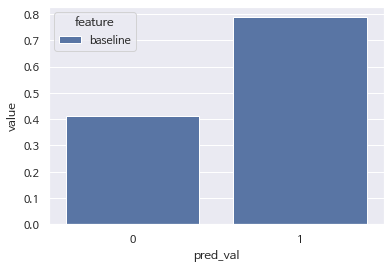

In [10]:
sns.barplot(x='pred_val', y='value', data=df, hue='feature')

In [11]:
base_result

[{'value': 0.41033638, 'pred_val': '0', 'feature': 'baseline'},
 {'value': 0.7875895, 'pred_val': '1', 'feature': 'baseline'}]

# 함수생성

In [12]:
def visualize_change(idx_list, base_result):
    plt.figure(figsize = (13,12), dpi=150)
    for idx, i in enumerate(idx_list):
        #도화지 설정
        plt.subplot(4,3,1+idx)
        plt.title(str(COLS[i]))
        plt.ylim(0,1)
        #Copy base_mean, cols
        result1 = base_result.copy()
        save_cols = X_test[:,:,i].copy()
        #Change all values to 1
        X_test[:,:,i] = 1
        #Predict
        pred = model.predict(X_test)
        #Result
        result1.append({'value' : np.mean(pred[s_index]),'pred_val':'0', 'feature' : str(COLS[i])})
        result1.append({'value' : np.mean(pred[d_index]),'pred_val':'1', 'feature' : str(COLS[i])})
        df = pd.DataFrame(result1)
        #Plot
        ax = sns.barplot(x='pred_val', y='value', data=df, hue='feature')
        ax.get_legend().remove()
        #Value Annotation
        for container in ax.containers:
            ax.bar_label(container)
        #값 복원
        X_test[:,:,i] = save_cols
    plt.tight_layout()

# PRE

In [13]:
pre_top10 = fi[fi['Type']=='PRE'].feature[:10].to_list()
pre_top10

[409606211,
 74606211,
 67434504,
 54817525,
 10019055302,
 54858516,
 74706811,
 45006701,
 4003822,
 63323016501]

In [14]:
pre_index = [COLS.index(i) for i in pre_top10]
pre_index

[2195, 1276, 1081, 982, 2744, 1011, 1306, 845, 469, 3820]

CPU times: user 8.18 s, sys: 5.88 s, total: 14.1 s
Wall time: 4.64 s


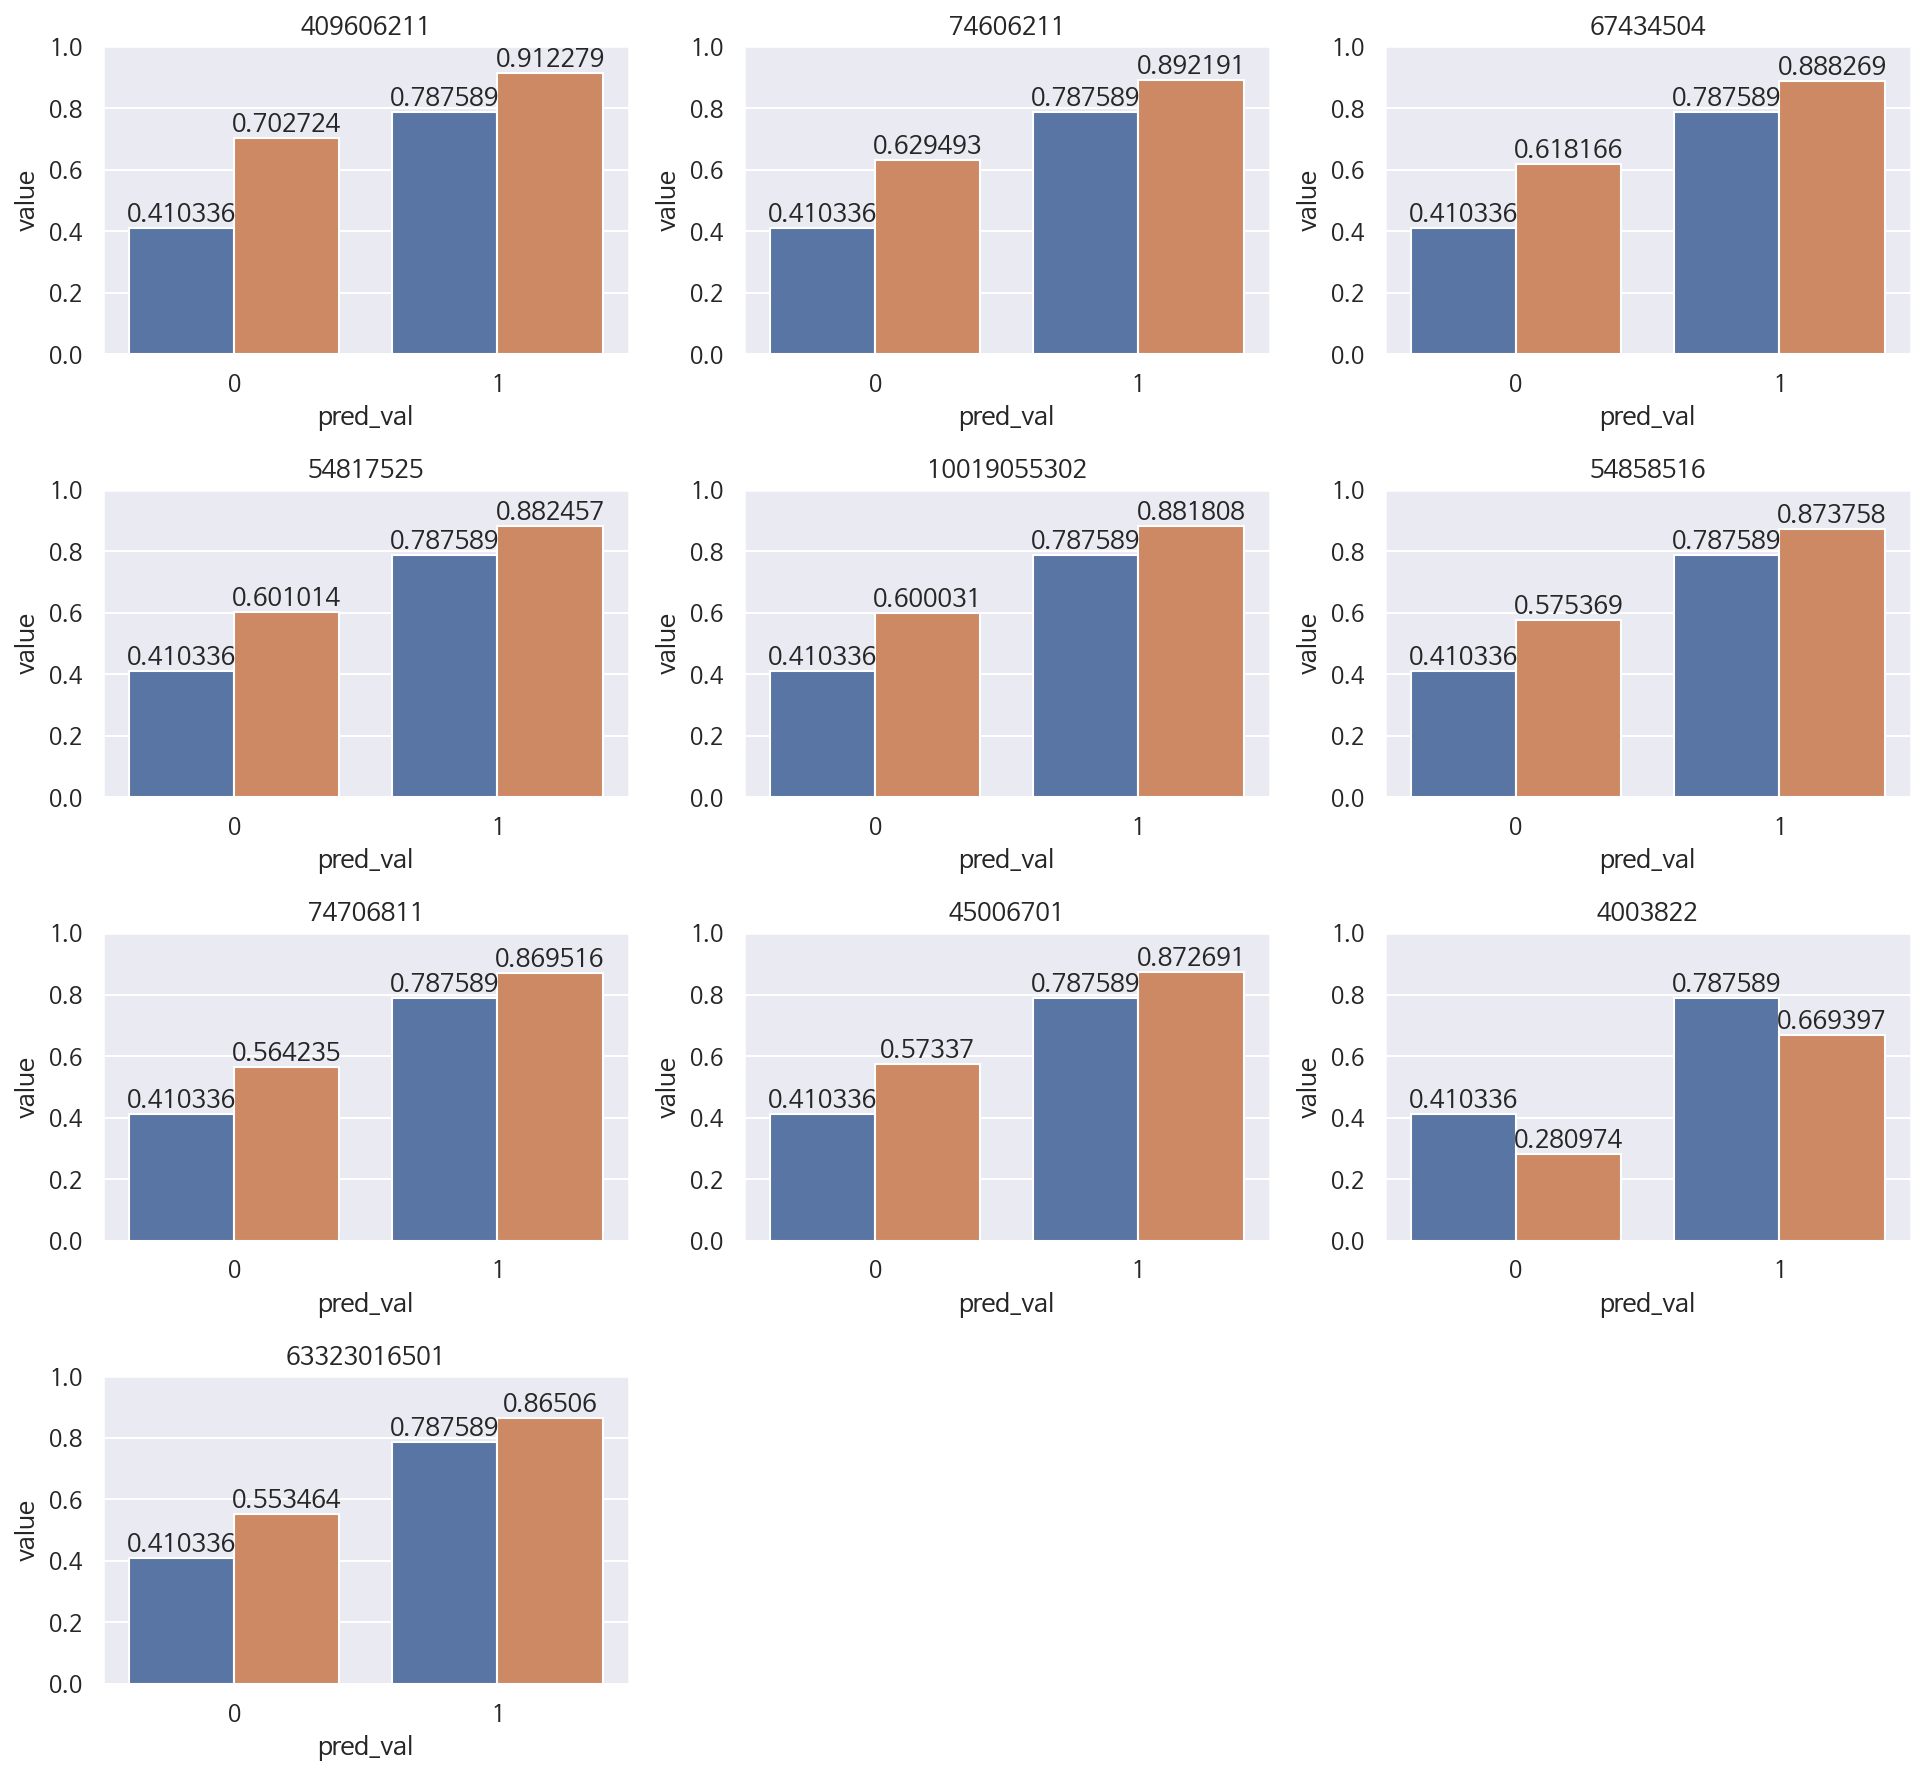

In [15]:
%%time
visualize_change(pre_index, base_result)

# LAB

In [16]:
lab_top10 = fi[fi['Type']=='LAB'].feature[:10].to_list()
lab_top10

lab_index = [COLS.index(i) for i in lab_top10]
lab_index

[37, 162, 119, 157, 26, 8, 17, 220, 139, 52]

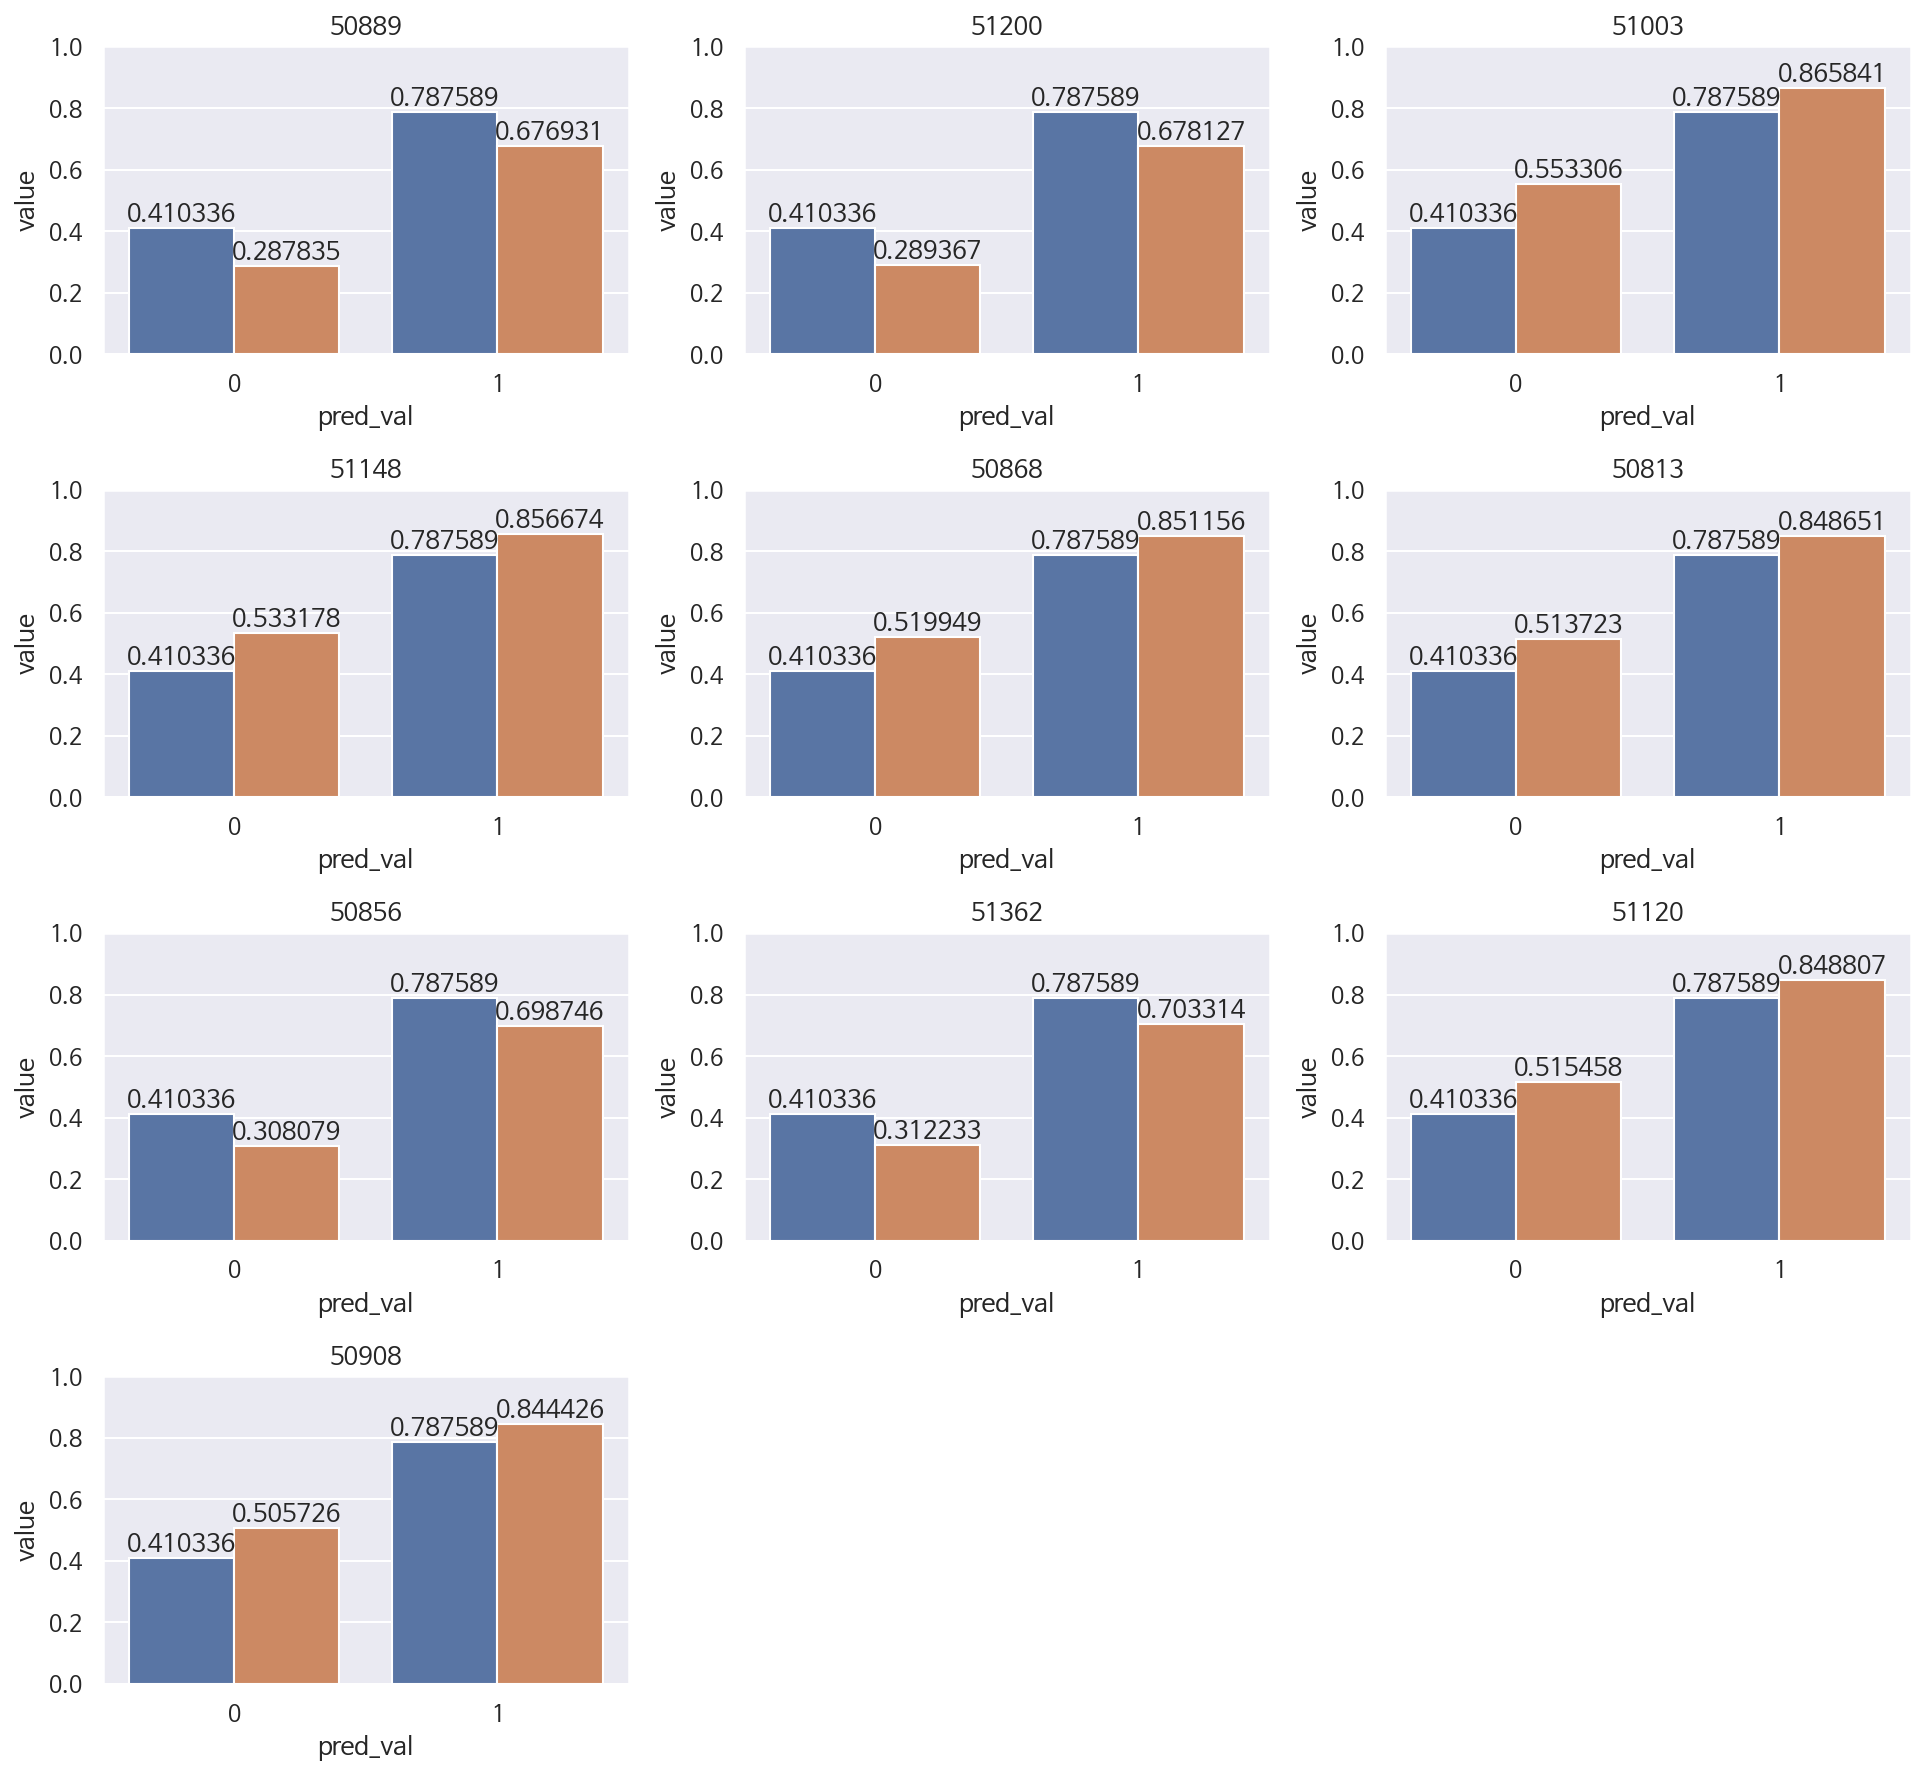

In [17]:
visualize_change(lab_index, base_result)

# PRO

In [18]:
pro_top10 = fi[fi['Type']=='PRO'].feature[:10].to_list()
pro_top10

pro_index = [COLS.index(i) for i in pro_top10]
pro_index

[383, 392, 301, 312, 394, 395, 376, 307, 341, 369]

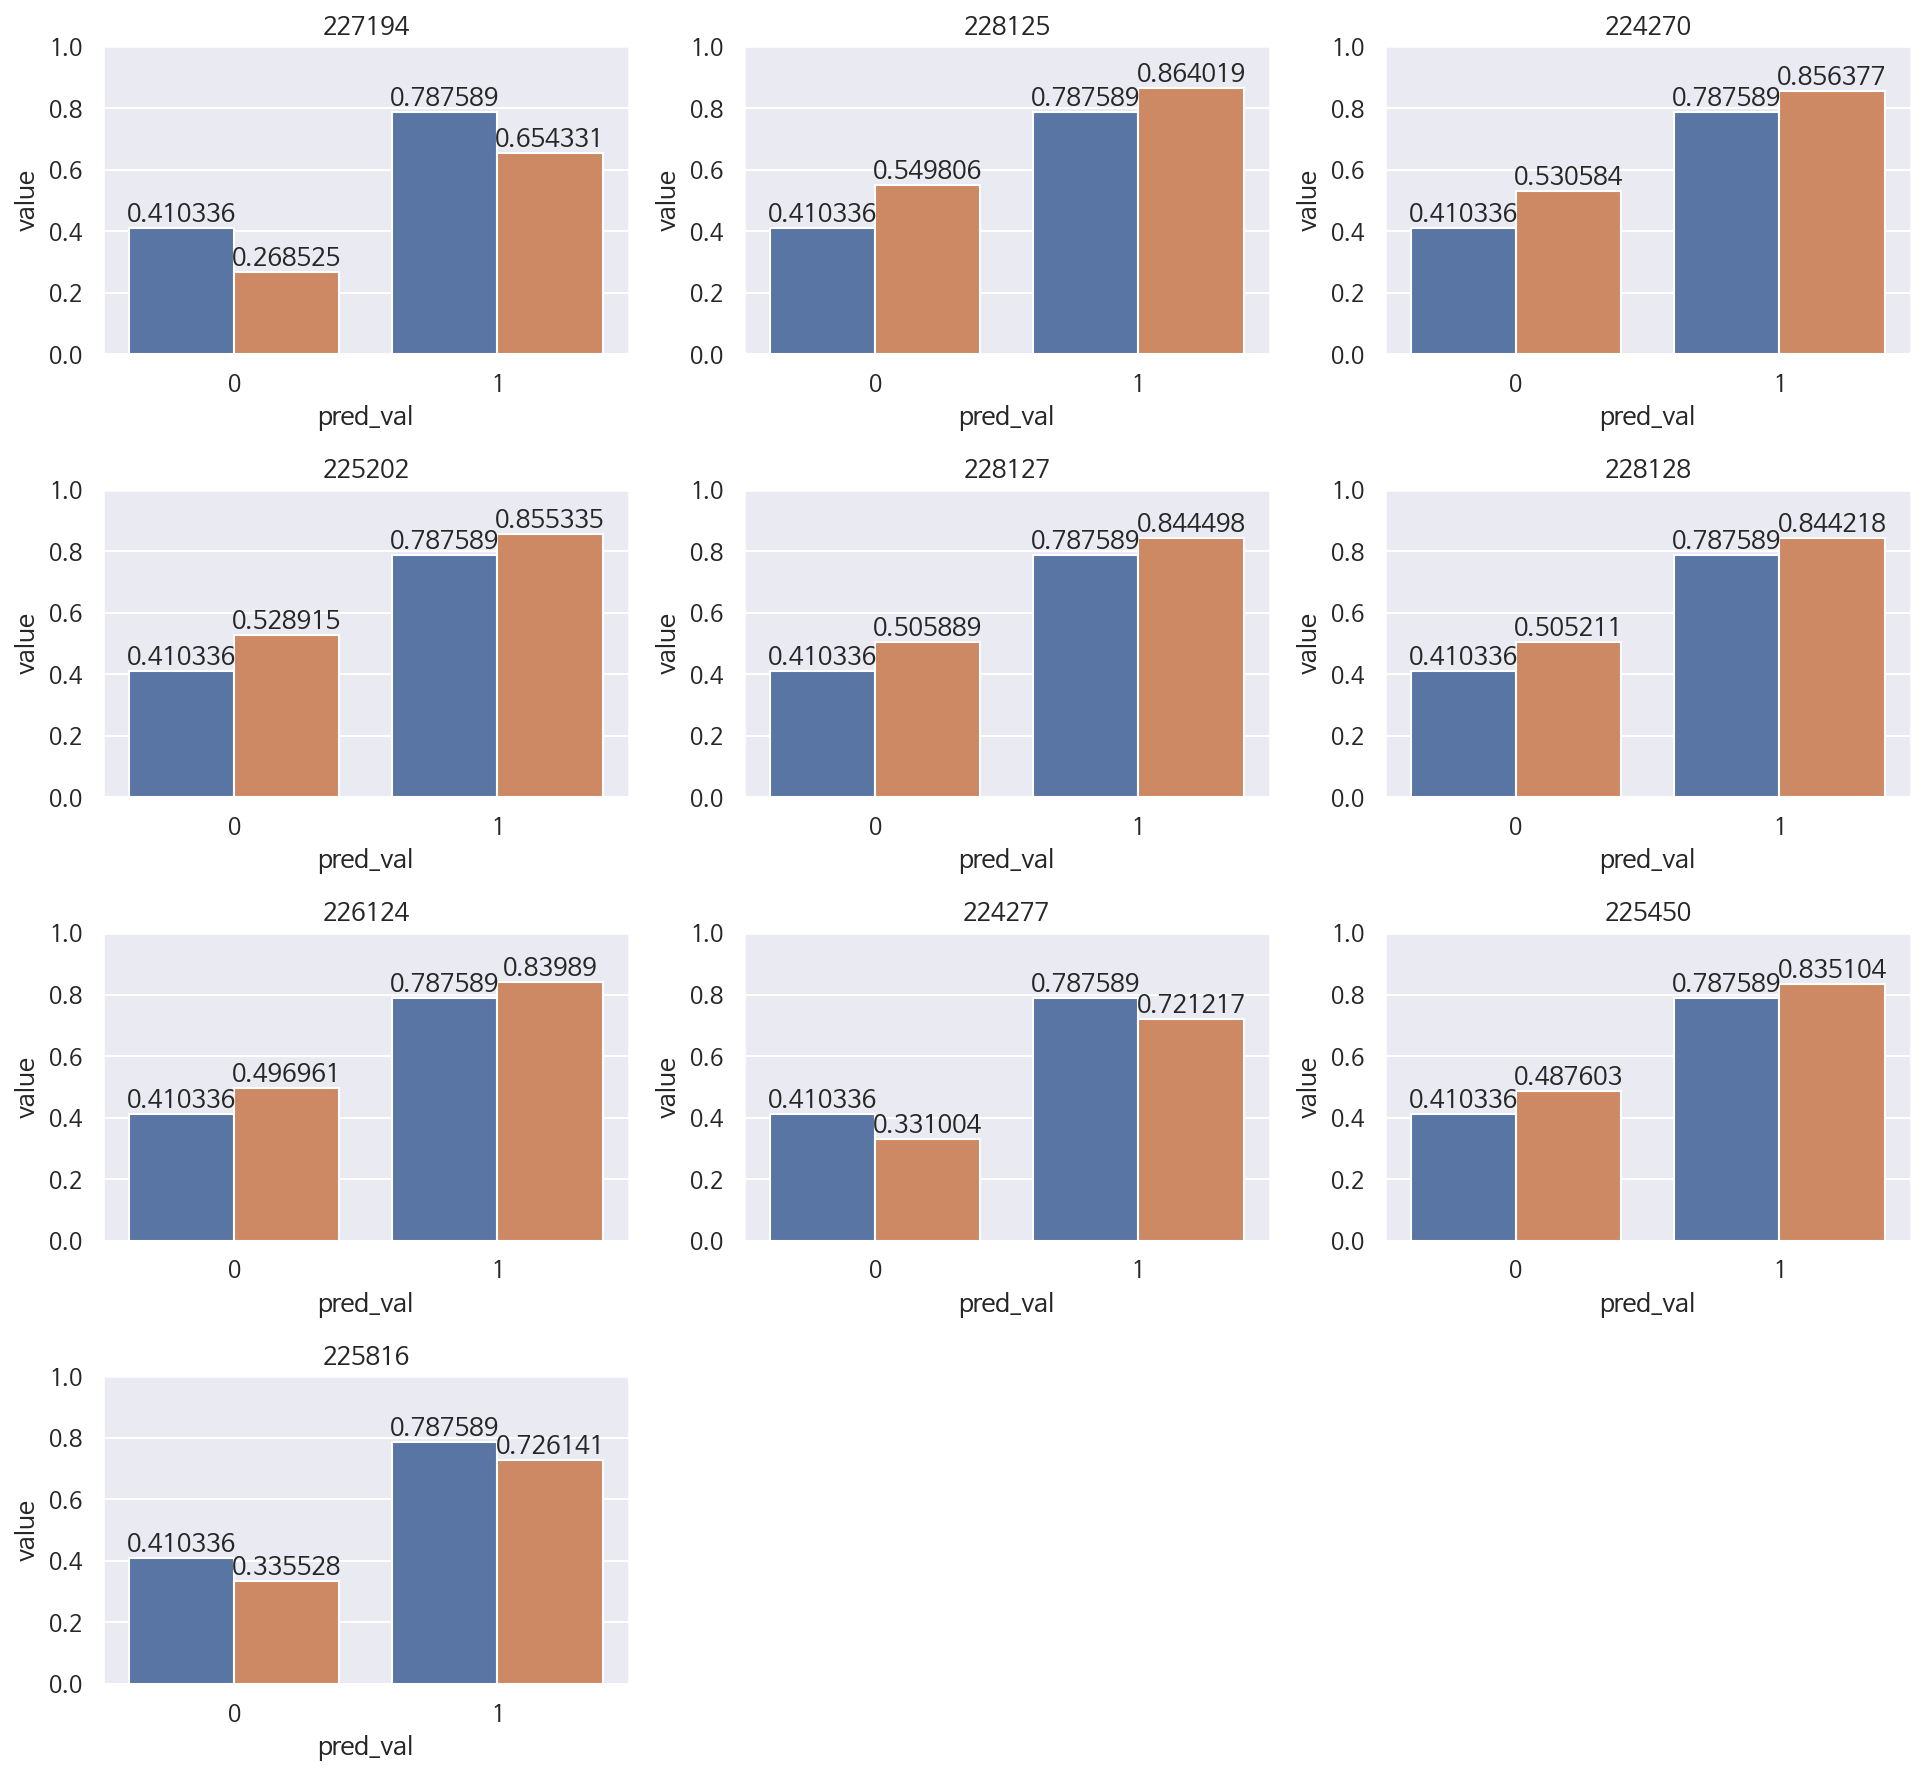

In [19]:
visualize_change(pro_index, base_result)

# 결론
위 barplot은 예측값의 평균이기 때문에 0의 경우 높아지면 예측률이 낮아지는 것이고 1의 경우 높아지면 예측률이 좋아지는 것으로 판단한다.
- baseline보다 평균예측값이 작은 경우, 생존자(0) - 생존예측률 증가 / 사망자(1) - 사망예측률 감소
    - 생존에 관련있는 feature
- baseline보다 평균예측값이 큰 경우, 생존자(0) - 생존예측률 감소 / 사망자(1) - 사망예측률 증가
    - 사망에 관련있는 feature